# Competition : APTOS 2019 Blindness Detection

- Computer Vision
- Image classification : 0 - No DR / 1 - Mild / 2 - Moderate / 3 - Severe / 4 - Proliferative DR
- Evaluation : Cohen's quadratically weighted kappa -> Making it as regression problem <br>
https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps
- Datasets : Train set(3662), Test set(1928) -> Need for data augmentation or find additional data  <br>
https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images
- Image size : width(2896) height(1944)

***
## Notebook 1. (ratthachat) APTOS : Eye Preprocessing in Diabetic Retinopathy
https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

### Datasets
'aptos2019-blindness-detection','diabetic-retinopathy-resized','retinopathy-train-2015' -> later two just for testing the preprocessing methods

### Data Preprocessing 
- 1) Prior ideas
    - Reducing lighting-condition effects : convert the image to gray scale
    - Ben Graham Method : Gray scale + Lighting condition
    - Auto-Cropping uninformative black areas <br>
limitations : might not work to some outliers, works well with gray scale images but not to color images

- 2) Improved ideas : Modified Ben Method + Circle crop
    - Modified Ben Method : For color version, note that I use argument sigmaX = 30 of cv2.GaussianBlur, where Ben actually used sigmaX = 10 which may have better performance. I just feel that this sigmaX = 30 or sigmaX = 50 make beautiful [sometimes bloody] yellow moon pictures.
    - Circle crop(Create circular crop around image center) 

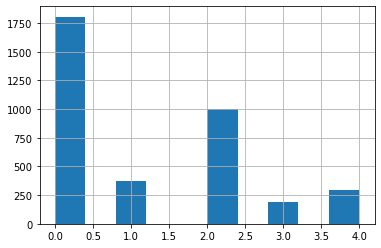

In [6]:
import os, sys
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

y.hist()

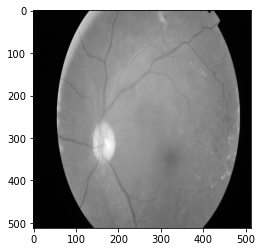

In [8]:
path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" #example
IMG_SIZE = 512

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

fig = plt.figure()
plt.imshow(image, cmap='gray')

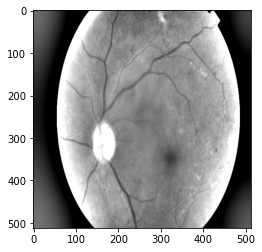

In [9]:
path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" #example
IMG_SIZE = 512

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image = cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # insightful way to improve lighting condition

fig = plt.figure()
plt.imshow(image, cmap='gray')


In [4]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

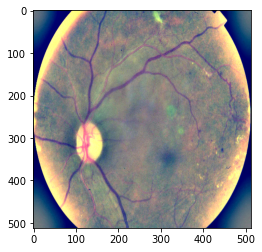

In [7]:
#Modified Ben Method with crop_image_from_gray not circle crop
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" #example
IMG_SIZE = 512

image = load_ben_color(path,sigmaX=30)
fig = plt.figure()
plt.imshow(image)

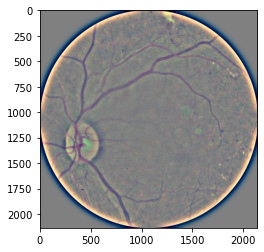

In [8]:
#Modified Ben Method with crop_image_from_gray with circle crop
def circle_crop(path, sigmaX=10):   
    
    img = cv2.imread(path)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" #example

image = circle_crop(path,sigmaX=30)
fig = plt.figure()
plt.imshow(image)

***
## Notebook 2 : [tanlikesmath] Intro APTOS Diabetic Retinopathy (EDA & Starter)
https://www.kaggle.com/tanlikesmath/intro-aptos-diabetic-retinopathy-eda-starter/ <br>
Public Score 0.700638

### Datasets
competition datasets, ImageNet(transfer learning)

### Data Preprocessing
- Used fastai.vision to transform data : label, transform(resize), convert them into ImageDataBunch and finally, normalize them

### Training Model
- evaluation metric : cohen_kappa_score from sklearn.metrics
- Framework : pytorch (import fastai)
- Pretrained model : ResNet50
- parameter tuning : used learning rate finder (learn.lr_find())

### Test predictions
- test data augmentation : TTA(test-time augmentation) 
- Optimizing the quadratic kappa metric : OptimizedRounder from @abhishek

In [ ]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

***
## Notebook3 : pytorch inference kernel + lazy TTA
https://www.kaggle.com/abhishek/pytorch-inference-kernel-lazy-tta <br>
0.755951

### Datasets
- competition datasets

### Data preprocessing : from torchvision import transforms
(**Assuming not revealing preprocessing methods)

### Training Model
- Framework : Pytorch
- Pretrained Model : 'resnet101'

### Test prediction
- test data transform/augmentation

***
## Notebook 4: APTOS 2019: DenseNet Keras Starter
https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter

### Datasets : Competition datasets, ImageNet

### Data preprocessing
- Resize Images: We will resize both the training and test images to 224x224, so that it matches the ImageNet format.
- Mixup & Data Generator: We show how to create a data generator that will perform random transformation to our datasets (flip vertically/horizontally, rotation, zooming). This will help our model generalize better to the data, since it is fairly small (only ~3000 images).

### Training Model
- Pretrained model : DenseNet-121 pre-trained on ImageNet
- Adam for 15 epochs

***
## Notebook 5 : Starter kernel for > 0.79 (Public Score 0.783583)
https://www.kaggle.com/drhabib/starter-kernel-for-0-79 <br>
    public score : 0.783583
### Datasets
- competition dataset, private datase

### Data preprocessing
- only resized the data

### Training Model
- pytorch, fastai
- Pretrained model : 'efficientnet-b5'
- used private dataset to train locally, and only uploaed the weights
- This kernel doesn't use optimized KAPPA

***
## Notebook 6 : EfficientNetB5 with Keras (APTOS 2019)
https://www.kaggle.com/carlolepelaars/efficientnetb5-with-keras-aptos-2019

### Datasets
- Competition datasets

### Data preprocessing
- Using Notebook 1's idea (https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy)
- Data augmentation : flip the data both horizontally and vertically, and then divide the data by 128 for normalization
    
### Training Model
- Framework : Keras
- Pretrained model : EfficientNet(pretrained on ImageNet, which introduces a systematic way to scale CNN in a nearly optimal way) B5 version -> Image size = (456, 456, 3)
- Optimizer : RAdam(it often yields better convergence than Vanilla Adam) by CyberZHG  
- Group Normalization instead of Batch Normalization (since it becomes unstable with small batch sizes (<16))
- We also stop training if the MSE on the validation set doesn't go down for 4 epochs. This way we can counter overfitting. (cf. Another option we could use is to directly use Quadratic Weighted Kappa as a loss function)